In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from functools import reduce

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score,v_measure_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

from scipy import stats

CACHE_DIR = Path(Path(os.getenv('APP_DIR')), '.cache')
NANOHUB_CACHE = Path(CACHE_DIR, 'nanohub')
NANOHUB_METRICS_CACHE = Path(CACHE_DIR, 'nanohub_metrics')


def create_silhouette_visual(sample, kmeans: KMeans, clusters: list = [2,3,4,5]):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in clusters:
        q, mod = divmod(i, 2)

        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(sample)
        
        
def display_cluster_info(X_scaled, clusters: [] = [2,3,4,5,6,7,8,9,10]):
    km_scores= []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
    
    fig, ax = plt.subplots(5, 2, figsize=(15,8))

    for i in clusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X_scaled)
        preds = kmeans.predict(X_scaled)
        km_scores.append(-kmeans.score(X_scaled))
        print("Score for number of cluster(s) {}: {}".format(i,kmeans.score(X_scaled)))
        km_scores.append(-kmeans.score(X_scaled))

        silhouette = silhouette_score(X_scaled,preds)
        km_silhouette.append(silhouette)
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

        db = davies_bouldin_score(X_scaled,preds)
        db_score.append(db)
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

        display("Centroids - ")
        print(kmeans.cluster_centers_)
        
        q, mod = divmod(i, 2)
    
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(X_scaled)

        print("-"*100) 



In [2]:
def read_csv(path):
    return pd.read_csv(path,index_col=False)

recency_df = read_csv(Path(CACHE_DIR, 'recency.csv'))
frequency_df = read_csv(Path(CACHE_DIR, 'frequency.csv'))
monetary_df = read_csv(Path(CACHE_DIR, 'monetary.csv'))

In [3]:
data_frames = [recency_df, frequency_df, monetary_df]

In [4]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on='user',
                                            how='outer'), data_frames)

In [5]:
num_clusters = 5

In [6]:
df_merged = df_merged[df_merged['Monetary'] > 1]

In [7]:
#taking log of RFM Feature
df_merged['recency_log'] = df_merged['Recency'].apply(np.log)
df_merged['frequency_log'] = df_merged['Frequency'].apply(np.log)
df_merged['monetary_log'] = df_merged['Monetary'].apply(np.log)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


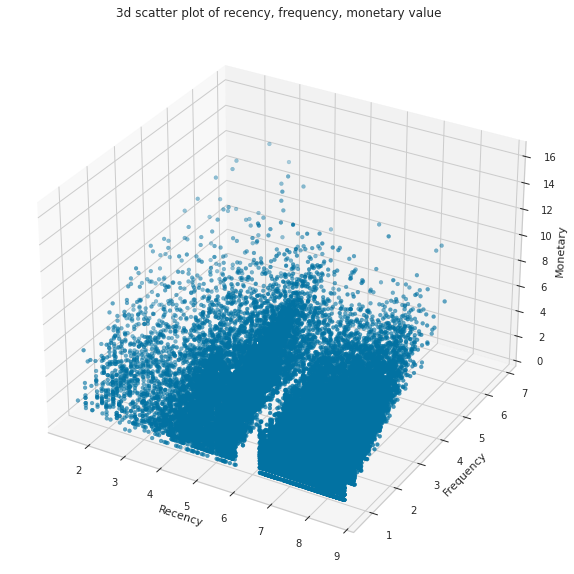

In [8]:
#3d scatter plot of recency, frequency, monetary value
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xs = df_merged.recency_log
ys = df_merged.frequency_log
zs = df_merged.monetary_log
ax.scatter(xs, ys, zs, s=15)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3d scatter plot of recency, frequency, monetary value')
plt.show()

In [9]:
users = df_merged

In [10]:
users['OverallScore'] = users['RecencyCluster'] + users['FrequencyCluster']  + users['MonetaryCluster'] 


In [11]:
users_scores = users
display(users.groupby('OverallScore')['Recency','Frequency','Monetary'].mean())

/tmp/ipykernel_8178/4054827243.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(users.groupby('OverallScore')['Recency','Frequency','Monetary'].mean())


,Recency,Frequency,Monetary
OverallScore,,,
0,3019.191724,4.786483,39.590219
1,455.078511,5.610493,676.218398
2,3936.098082,8.472227,1727.042369
3,1682.848620,6.041413,269.119794
4,1672.845095,33.166954,1672.595525
5,1414.467532,89.103896,63558.350649
6,217.050000,75.200000,142842.100000
7,407.529052,9.327217,28569.342508
8,268.282051,48.931624,37767.649573


In [12]:
display(users.groupby('OverallScore')['Recency'].count())


OverallScore
0      7709
1     13132
2      5995
3      8548
4       581
5        77
6        20
7       327
8       117
9        25
10        5
12        2
Name: Recency, dtype: int64

In [13]:
rfm = users[['user', 'Recency','Frequency','Monetary']]
rfm.set_index('user', inplace=True)

In [14]:
is_inliner = (np.abs(stats.zscore(rfm)) < 3).all(axis=1)
rfm = rfm[is_inliner]

In [15]:
rfm_corr = rfm.corr()


In [16]:
log_rfm = np.log(rfm)
# use fit_transfome from StandardScaler to standardize the data (mean=0, std=1)
scaler = StandardScaler()
scaled_rfm_array = scaler.fit_transform(log_rfm)
scaled_rfm = pd.DataFrame(
    scaled_rfm_array,
    columns=rfm.columns,
    index=rfm.index,
)

In [17]:
kmeans = KMeans(n_clusters=num_clusters, random_state=1)
kmeans.fit(scaled_rfm)
# extract the cluster labels from thte fitted model
cluster_labels = kmeans.labels_

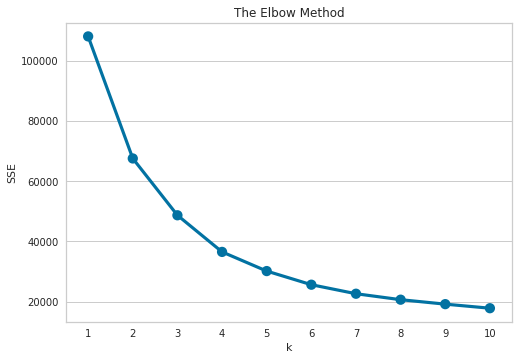

In [18]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaled_rfm)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
    
# Plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE') 
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

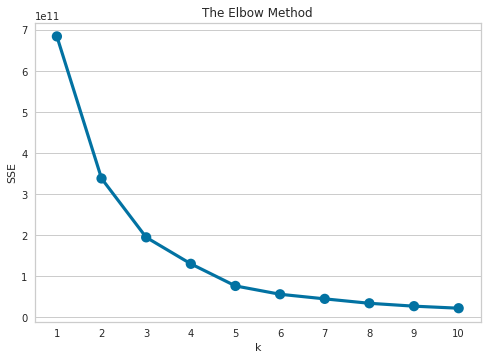

In [19]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
    
# Plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE') 
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [20]:
feature=['recency_log','frequency_log','monetary_log']
X=df_merged[feature].values

In [21]:
scaler=MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)

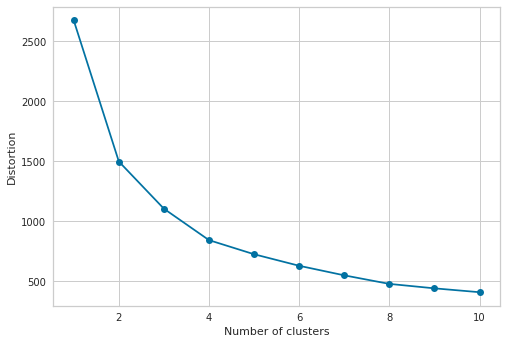

In [22]:
distortions = []
for i in range(1, 11):
  km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
  km.fit(X)
  distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [23]:


clustering=KMeans(
    n_clusters=num_clusters, 
    init='k-means++',
    n_init=10,
    max_iter=1000,
    random_state=0
).fit(X)

print("Clusters:",np.unique(clustering.labels_))

s=pd.Series(clustering.labels_)

df_merged['Cluster_Label']=clustering.labels_

print(s.value_counts())
print(len(s))


Clusters: [0 1 2 3 4]
0    18056
2     7353
4     5316
3     3915
1     1898
dtype: int64
36538


/tmp/ipykernel_8178/1558756540.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(figure,elev=30,azim=150)


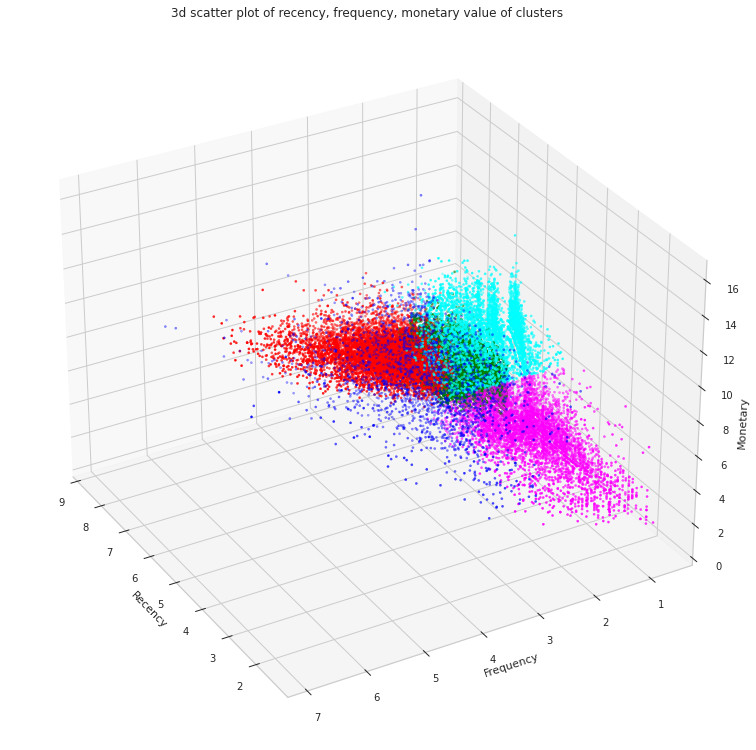

In [24]:

figure=plt.figure(figsize=(12,7))
ax=Axes3D(figure,elev=30,azim=150)

figure.set_size_inches(10,10)
for i,colors in zip(range(0,7),['green','blue','red','cyan','magenta','yellow','black']):
        ax.scatter(
            df_merged.loc[:,['recency_log']][df_merged.Cluster_Label==i], 
            df_merged.loc[:,['frequency_log']][df_merged.Cluster_Label==i], 
            df_merged.loc[:,['monetary_log']][df_merged.Cluster_Label==i],
            s=5,
            color=colors)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(map(lambda x:str(x),range(0,7)))
plt.title('3d scatter plot of recency, frequency, monetary value of clusters')

plt.show()

In [25]:
def plot_cluster(num: int, df: pd.DataFrame):
    figure = plt.figure(figsize=[5.0, 5.0])
    fig.suptitle('Cluster %d' % num)

    ax = Axes3D(figure, elev=20, azim=160)
    figure.set_size_inches(10,10)
    ax.scatter(df.loc[:,['Recency']][df.Cluster_Label==num], 
               df.loc[:,['Frequency']][df.Cluster_Label==num], 
               df.loc[:,['Monetary']][df.Cluster_Label==num], 
               s=10,
               color='green',marker='^')

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    plt.title("Cluster %d" % num)
    plt.show()

/tmp/ipykernel_8178/4226247106.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure, elev=20, azim=160)


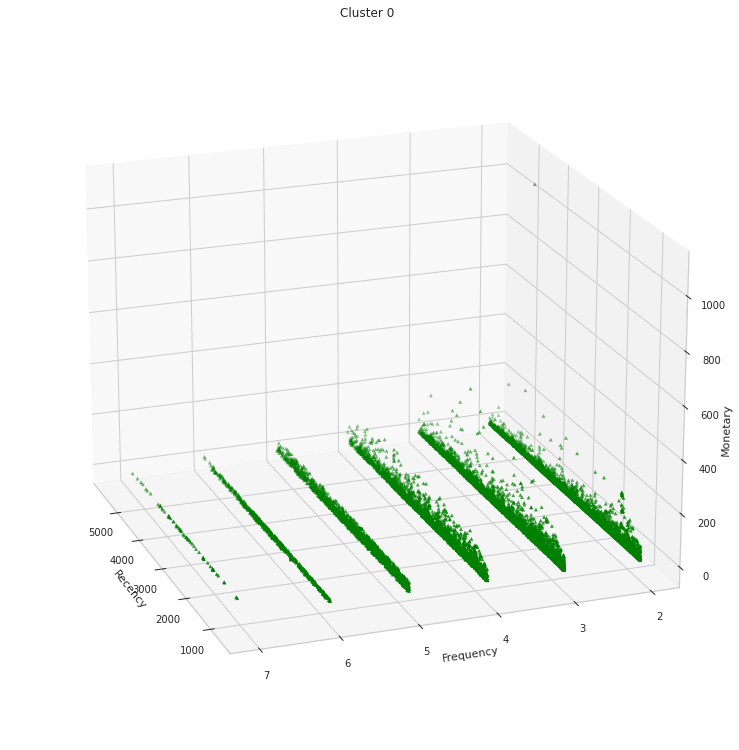

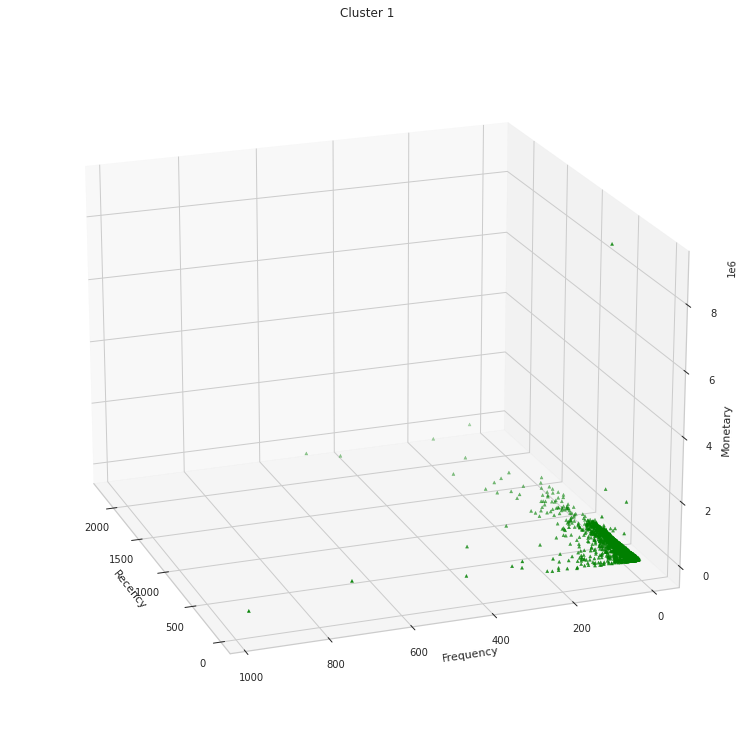

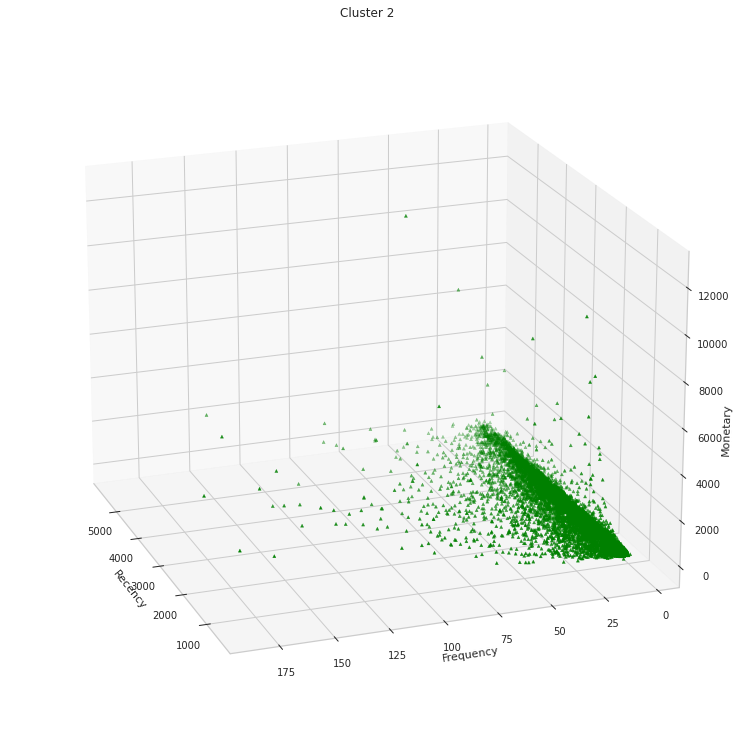

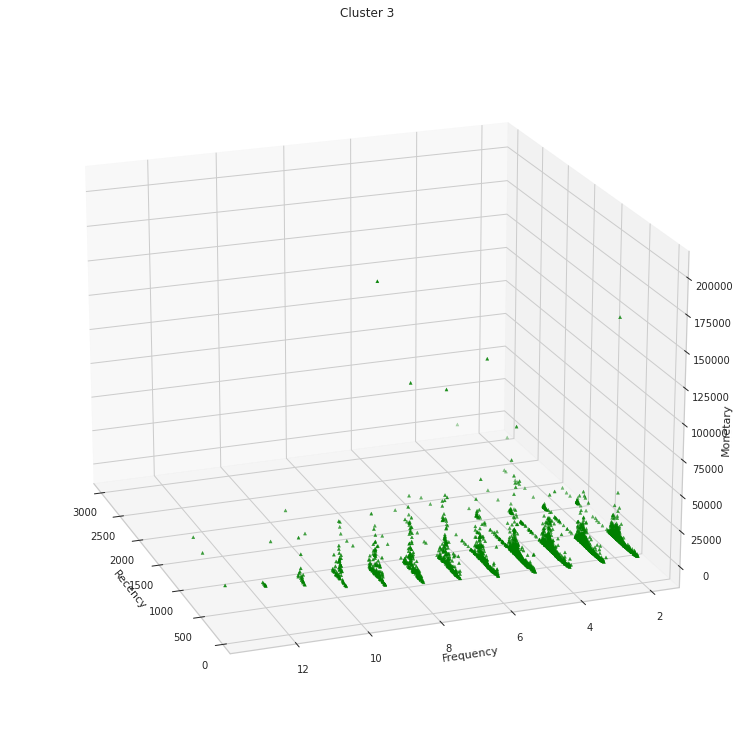

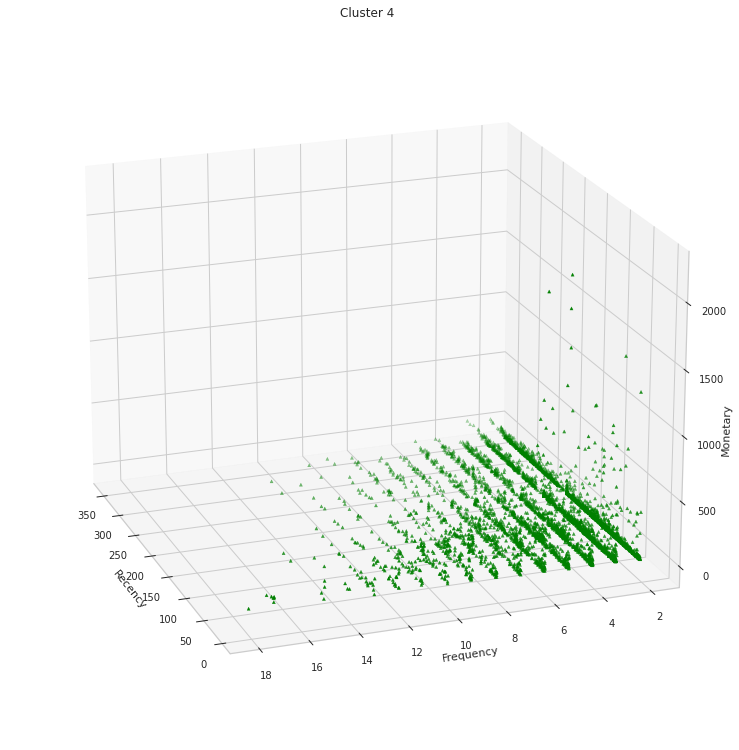

In [26]:
for i in range(0, num_clusters):
    plot_cluster(i, df_merged)

In [ ]:
display_cluster_info(X)

Score for number of cluster(s) 2: -1499.206591975573
Silhouette score for number of cluster(s) 2: 0.465480287550356
Davies Bouldin score for number of cluster(s) 2: 1.0105008429569724


'Centroids - '

[[0.51188018 0.14857147 0.29676272]
 [0.87114608 0.11765401 0.15338847]]


In [ ]:
df_merged['Cluster_Label']=clustering.labels_

In [ ]:
#Difference in recency among clusters
plt.figure(figsize=(12,7))
sns.boxplot(x='Cluster_Label',y='Recency',data=df_merged)
plt.title('Difference in recency among clusters')
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Cluster_Label',y='Monetary',data=df_merged)
plt.title('Difference in monetary value among clusters')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D,axes3d


figure=plt.figure(figsize=(12,7))
ax=Axes3D(figure,elev=30,azim=150)

figure.set_size_inches(10,10)
for i,colors in zip(range(0,7),['green','blue','red','cyan','magenta','yellow','black']):
        ax.scatter(
            df_merged.loc[:,['recency_log']][df_merged.Cluster_Label==i], 
            df_merged.loc[:,['frequency_log']][df_merged.Cluster_Label==i], 
            df_merged.loc[:,['monetary_log']][df_merged.Cluster_Label==i], 
            s=5,
            color=colors)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(map(lambda x:str(x),range(0,7)))
plt.title('3d scatter plot of recency, frequency, monetary value of clusters')

plt.show()